# MSXV - FSGP & ASC '24 - Strategy
by Kostubh Agarwal & Rodrigo Tiscareno

## About

The objective(s) of ASC are the following:

1. To complete the American Solar Challenge base route without trailering.
2. To complete as many official miles as possible. (1st Tiebreaker)
3. To complete the distance in the shortest elapsed time. (2nd Tiebreaker)

To sucessfully complete these objectives one must design a good solar car and a good race strategy. Race strategy comes down to a single question:

### **What speed should one drive at?**

The code below uses route data, elevation data, weather data, and solar irradiance data to help predict the performance of the car for various velocities.

# Table of Contents

1. [MSXV - FSGP & ASC '24 - Strategy](#MSXV---FSGP-&-ASC-'24---Strategy)
   1. [About](#About)
      1. [What speed should one drive at?](#What-speed-should-one-drive-at?)
2. [Visualizations](#Visualizations)
3. [Database](#Database)
4. [Solver](#Solver)
5. [Stage Overview](#Stage-Overview)
   1. [1A](#1A)
      1. [Distance](#Distance)
      2. [Elevation Gain](#Elevation-Gain)
      3. [Total Irradiance](#Total-Irradiance)
   2. [1B](#1B)
   3. [2C](#2C)
   4. [2D](#2D)
6. [Data Visualizations](#Data-Visualizations)
   1. [Velocity Selection](#Velocity-Selection)
   2. [Velocity Specific](#Velocity-Specific)
   3. [Irradiance Time Graph](#Irradiance-Time-Graph)
7. [FAQ](#FAQ)



In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from windrose import WindroseAxes
from tqdm import tqdm
import pandasql as psql
import math

from db_funcs import fetch_data, connect_to_db, map_distance_to_id, map_distance_to_irradiance, load_data_to_memory


In [6]:
base_route_df, irradiance_df = load_data_to_memory()

## Visualizations

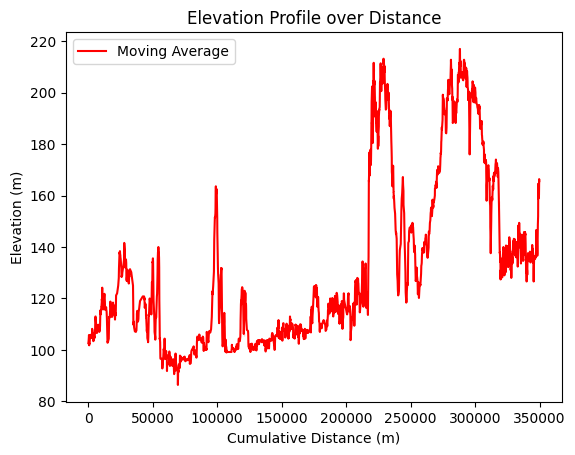

In [7]:
SYMBOL = '1B'

query = f"SELECT * FROM base_route_df WHERE symbol = '{SYMBOL}' ORDER BY id"
df = psql.sqldf(query, locals())

window_size = 5
df['moving_avg_elevation'] = df['elevation'].rolling(window=window_size).mean()

sns.lineplot(x='stage_elapsed_distance', y='moving_avg_elevation', data=df, label='Moving Average', color='red')
plt.title('Elevation Profile over Distance')
plt.xlabel('Cumulative Distance (m)')
plt.ylabel('Elevation (m)')
plt.show()

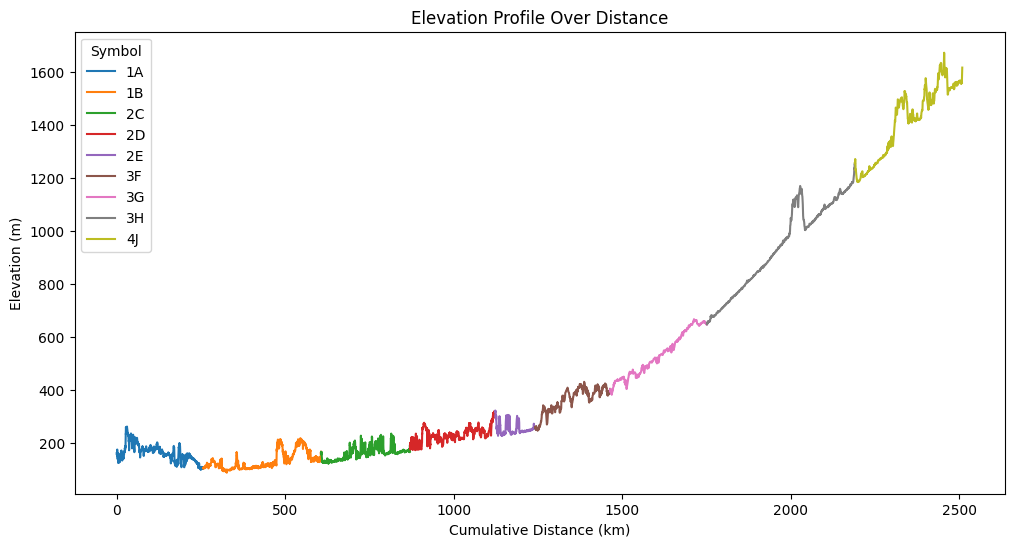

In [8]:
query = "SELECT * FROM base_route_df ORDER BY id"
df = psql.sqldf(query, locals())

df['geopy_elapsed_dist_km'] = df['geopy_elapsed_dist_m'] / 1000

window_size = 5
df['moving_avg_elevation'] = df['elevation'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x='geopy_elapsed_dist_km', y='moving_avg_elevation', hue='symbol', data=df, palette='tab10')
plt.title('Elevation Profile Over Distance')
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('Elevation (m)')
plt.legend(title='Symbol')
plt.ticklabel_format(style='plain', axis='x')
plt.show()


/var/folders/c1/s0gfrcl17njd06w_lmv6cvgm0000gn/T/ipykernel_26933/1654976208.py:2: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  df = psql.sqldf(query, locals())


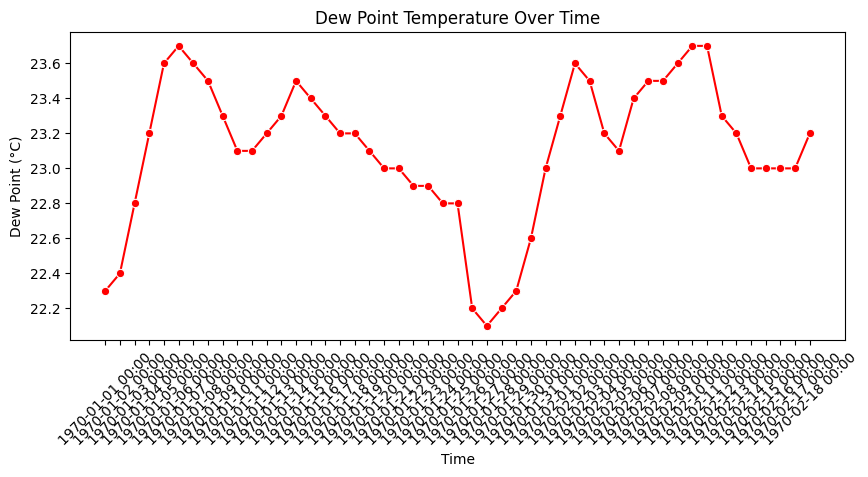

In [30]:
query = "SELECT * FROM irradiance_df WHERE route_model_id = '1A0' ORDER BY id"
df = psql.sqldf(query, locals())

plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x='period_end', y='dewpoint_temp', marker='o', color='red')
plt.title('Dew Point Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Dew Point (°C)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.show()


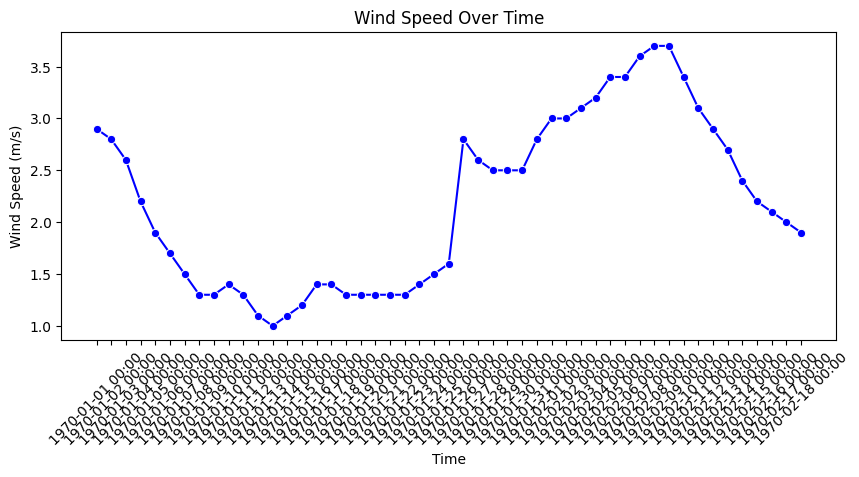

In [32]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x="period_end", y='wind_speed_10m', marker='o', color='blue')
plt.title('Wind Speed Over Time')
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.show()


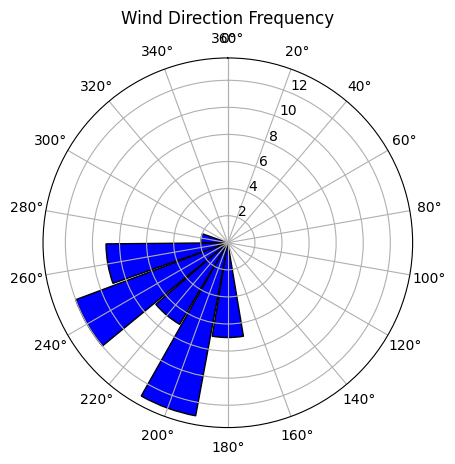

In [33]:
# Assuming 'wind_direction_10m' is in degrees and properly loaded into `data`
wind_directions = df['wind_direction_10m']  # example data

# Set up the bins for the histogram (18 bins cover 360 degrees, each bin is 20 degrees)
bins = np.linspace(0, 360, 19)

# Histogram data to count occurrences in each direction bin
counts, _ = np.histogram(wind_directions, bins)

# Setting up the plot
ax = plt.subplot(111, polar=True)
bars = ax.bar(np.deg2rad(bins[:-1]), counts, width=np.deg2rad(360/len(bins)), bottom=0.0, color='b', edgecolor='black')

ax.set_theta_zero_location('N')  # North at the top
ax.set_theta_direction(-1)  # Clockwise
ax.set_xticks(np.deg2rad(bins))  # Set the tick locations
ax.set_xticklabels([f'{int(angle)}°' for angle in bins])  # Label ticks with angles

plt.title('Wind Direction Frequency')
plt.show()


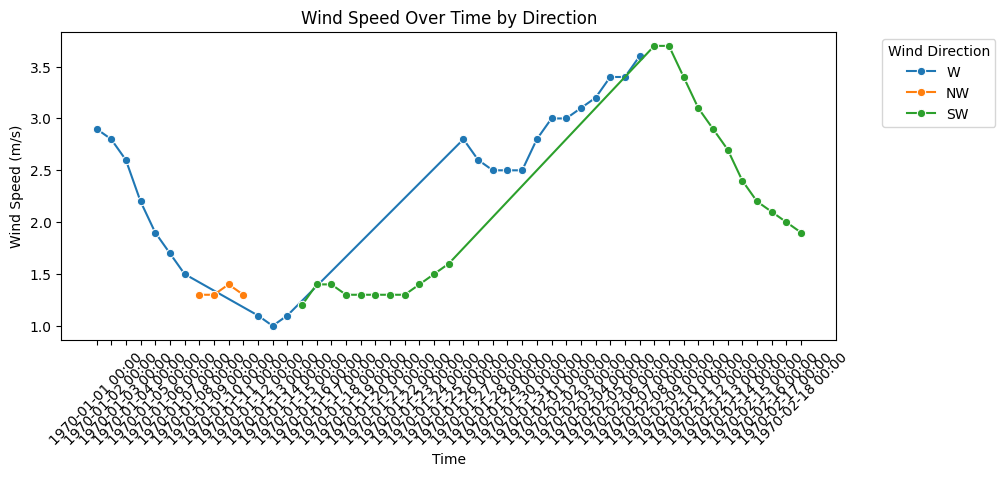

In [34]:
def categorize_direction(degrees):
    bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
    categories = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
    idx = np.digitize(degrees, bins, right=True)
    return categories[idx]

df['direction_category'] = df['wind_direction_10m'].apply(categorize_direction)

plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x="period_end", y='wind_speed_10m', hue='direction_category', marker='o', palette='tab10')
plt.title('Wind Speed Over Time by Direction')
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.legend(title='Wind Direction', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Database

| Route Name                       | Symbol |
|----------------------------------|--------|
| Nashville to Paducah             | 1A     |
| Paducah to Edwardsville          | 1B     |
| Edwardsville to Jefferson City   | 2C     |
| Jefferson City to Independence   | 2D     |
| Independence to Saint Joseph     | 2E     |
| Saint Joseph to Beatrice         | 3F     |
| Beatrice to Kearney              | 3G     |
| Kearney to Gering                | 3H     |
| Gering to Casper                 | 4J     |

To initialize/update database change the **stage_symbol** based on the table above.

In [3]:
connection = connect_to_db()

CONFIGURATION = dict(
    connection = connection,
    stage_symbol = '1A',
    replace_existing = True # Set to True if existing data should be refreshed, False otherwise -- recommended True
)

# %%capture

from irradiance import main as get_irradiance_data
get_irradiance_data(
    connection=CONFIGURATION['connection'],
    stage_symbol= CONFIGURATION['stage_symbol'],
    replace_existing = CONFIGURATION['replace_existing']
)

query = f"SELECT * FROM irradiance where LEFT(route_model_id, 2) = '{CONFIGURATION['stage_symbol']}' ORDER BY route_model_id, period_end"

# First 5 row
fetch_data(query).head()

Processing stages: 100%|██████████| 87/87 [06:19<00:00,  4.36s/it]


Database connection closed.


,id,air_temp,ghi,period_end,period,route_model_id,gti,clearsky_ghi,clearsky_gti,dewpoint_temp,precipitation_rate,relative_humidity,wind_direction_10m,wind_speed_10m,data_type,last_updated_time
0,95062,23,5,2024-07-05 11:00:00,0 days 00:30:00,1A0,5,7,6,22.5,1.2,96.0,220,2.0,live,2024-07-05 18:47:18.313609
1,95061,23,33,2024-07-05 11:30:00,0 days 00:30:00,1A0,32,48,34,22.5,2.1,96.9,231,2.0,live,2024-07-05 18:47:18.269038
2,95060,23,35,2024-07-05 12:00:00,0 days 00:30:00,1A0,34,113,76,22.6,2.1,96.6,253,1.9,live,2024-07-05 18:47:18.222848
3,95059,24,15,2024-07-05 12:30:00,0 days 00:30:00,1A0,15,196,147,22.8,0.6,96.1,275,2.1,live,2024-07-05 18:47:18.177953
4,95058,24,20,2024-07-05 13:00:00,0 days 00:30:00,1A0,20,290,236,23.2,0.6,95.6,292,2.6,live,2024-07-05 18:47:18.132688


## Solver

In [1]:
# Properties
m = 300  # mass (kg)
g = 9.81  # acceleration due to gravity (m/s^2)
C_r1 = 0.004  # rolling resistance coefficient 1
C_r2 = 0.052  # rolling resistance coefficient 2
C_d = 0.13  # drag coefficient
A_drag = 1.357  # cross-sectional area (m^2)
p = 1.293  # air density (kg/m^3)
n = 0.16  # efficiency of solar panel
A_solar = 4  # area of solar panel (m^2)
bat_capacity = 40 * 3.63 * 36  # pack capacity (Wh)

# Power (Out)
def rolling_resistance(v):
    return (m * g * C_r1 + 4 * C_r2 * v) * v

def drag_resistance(v):
    return 0.5 * p * C_d * A_drag * v ** 3

def gradient_resistance(v, theta):
    return m * g * np.sin(np.deg2rad(theta)) * v

# Power (In)
def solar_power(G):
    return A_solar * G * n

velocities = np.arange(1, 33)
times = np.arange(1, 28800, 900)
output = np.zeros((32, 32))
solar_power_values = np.zeros((32, 32))
rolling_resistance_values = np.zeros((32, 32))
drag_resistance_values = np.zeros((32, 32))
gradient_resistance_values = np.zeros((32, 32))
capacity_values = np.full((32, 32), bat_capacity)
i = 0
j = 0
t = 0

connection = connect_to_db()
total_iterations = len(velocities) * len(times)
pbar = tqdm(total=total_iterations, desc="Simulating....", unit="step")

base_route_df, irradiance_df = load_data_to_memory()

pbar = tqdm(total=total_iterations, desc="Simulating....", unit="step")

for i, v in enumerate(velocities):
    for j, t in enumerate(times):
        try: 
            d = v * t
            row_df = map_distance_to_id(base_route_df, '1A', d)['elevation'].values[0]
            row_df2 = map_distance_to_id(base_route_df, '1A', d * 2)['elevation'].values[0]
        except:
            continue
        theta = math.degrees(math.atan((row_df2 - row_df) / d))
        irradiance = map_distance_to_irradiance(irradiance_df, base_route_df, "1A", d, t)['ghi'].values[0]
        solar_power_values[i, j] = solar_power(irradiance)
        rolling_resistance_values[i, j] = rolling_resistance(v)
        drag_resistance_values[i, j] = drag_resistance(v)
        gradient_resistance_values[i, j] = gradient_resistance(v, theta)


        pbar.update(1)


pbar.close()

energy_consumed = - solar_power_values + rolling_resistance_values + drag_resistance_values + gradient_resistance_values # watt-hours

for j in range(1, 32):
    capacity_values[:, j] = capacity_values[:, j - 1] - energy_consumed[:, j - 1]



NameError: name 'np' is not defined

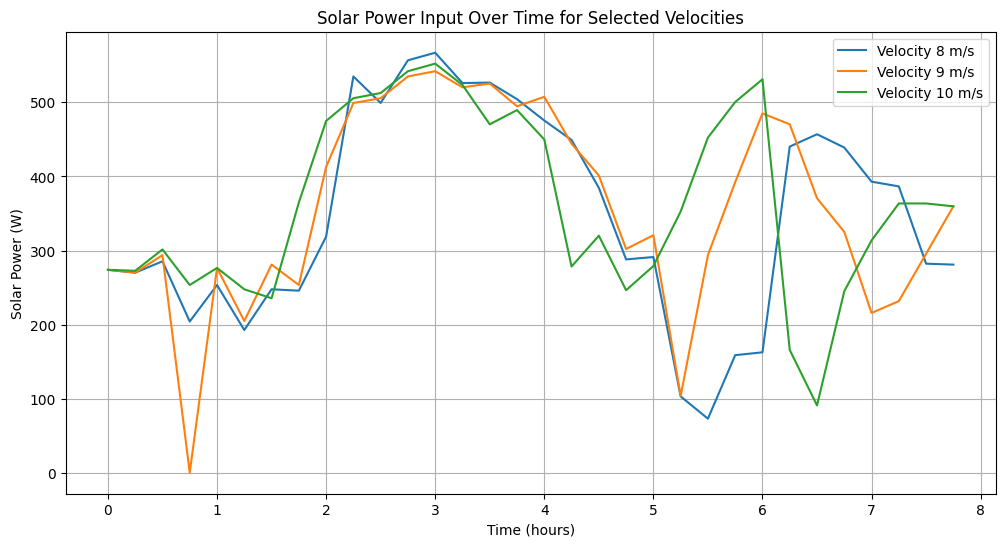

In [4]:
min_velocity = 8
max_velocity = 10

filtered_indices = np.where((velocities >= min_velocity) & (velocities <= max_velocity))[0]

plt.figure(figsize=(12, 6))
for i in filtered_indices:
    plt.plot(times / 3600, solar_power_values[i, :], label=f"Velocity {velocities[i]} m/s")

plt.title('Solar Power Input Over Time for Selected Velocities')
plt.xlabel('Time (hours)')
plt.ylabel('Solar Power (W)')
plt.legend()
plt.grid(True)
plt.show()

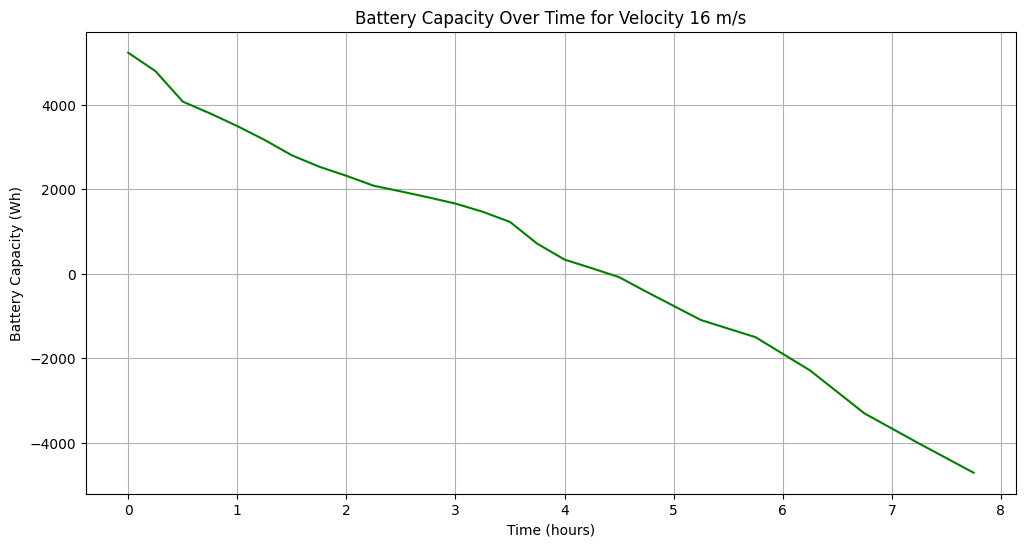

In [5]:
# Pick a specific velocity and plot over time
v_index = 15  # Example: index of the velocity array for which you want to plot
plt.figure(figsize=(12, 6))
plt.plot(times / 3600, capacity_values[v_index, :], color='green')
plt.title(f'Battery Capacity Over Time for Velocity {velocities[v_index]} m/s')
plt.xlabel('Time (hours)')
plt.ylabel('Battery Capacity (Wh)')
plt.grid(True)
plt.show()



# Stage Overview

# 1A


### Distance

In [7]:
from db_funcs import fetch_data

fetch_data("SELECT stage_elapsed_distance as distance_m FROM base_route where symbol='1A' order by id desc limit 1")

,distance_m
0,256632.550319


### Elevation Gain

In [8]:
fetch_data("""
WITH elevation_data AS (
    SELECT
        MIN(elevation) AS first_elevation,
        MAX(elevation) AS last_elevation
    FROM
        base_route
    WHERE symbol = '1A'
)
SELECT
    first_elevation,
    last_elevation,
    last_elevation - first_elevation AS elevation_gain
FROM
    elevation_data;      
""")

,first_elevation,last_elevation,elevation_gain
0,95.0,262.0,167.0


### Total Irradiance

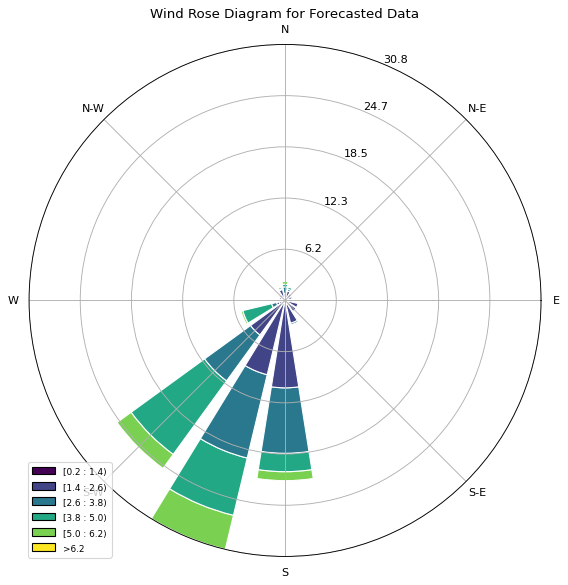

In [18]:
STAGE = '1A'

irradiance_df = fetch_data(f"SELECT * FROM irradiance WHERE LEFT(route_model_id, 2) = '{STAGE}' ORDER BY route_model_id, period_end")

def plot_wind_rose(df):
    ax = WindroseAxes.from_ax()
    ax.bar(df['wind_direction_10m'], df['wind_speed_10m'], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.title('Wind Rose Diagram for Forecasted Data')
    plt.show()
plot_wind_rose(irradiance_df)



In [ ]:
STAGE = '1A'

irradiance_df = fetch_data(f"SELECT * FROM irradiance WHERE LEFT(route_model_id, 2) = '{STAGE}' ORDER BY route_model_id, period_end")



## Data Visualizations

### Velocity Selection

<function matplotlib.pyplot.show(close=None, block=None)>

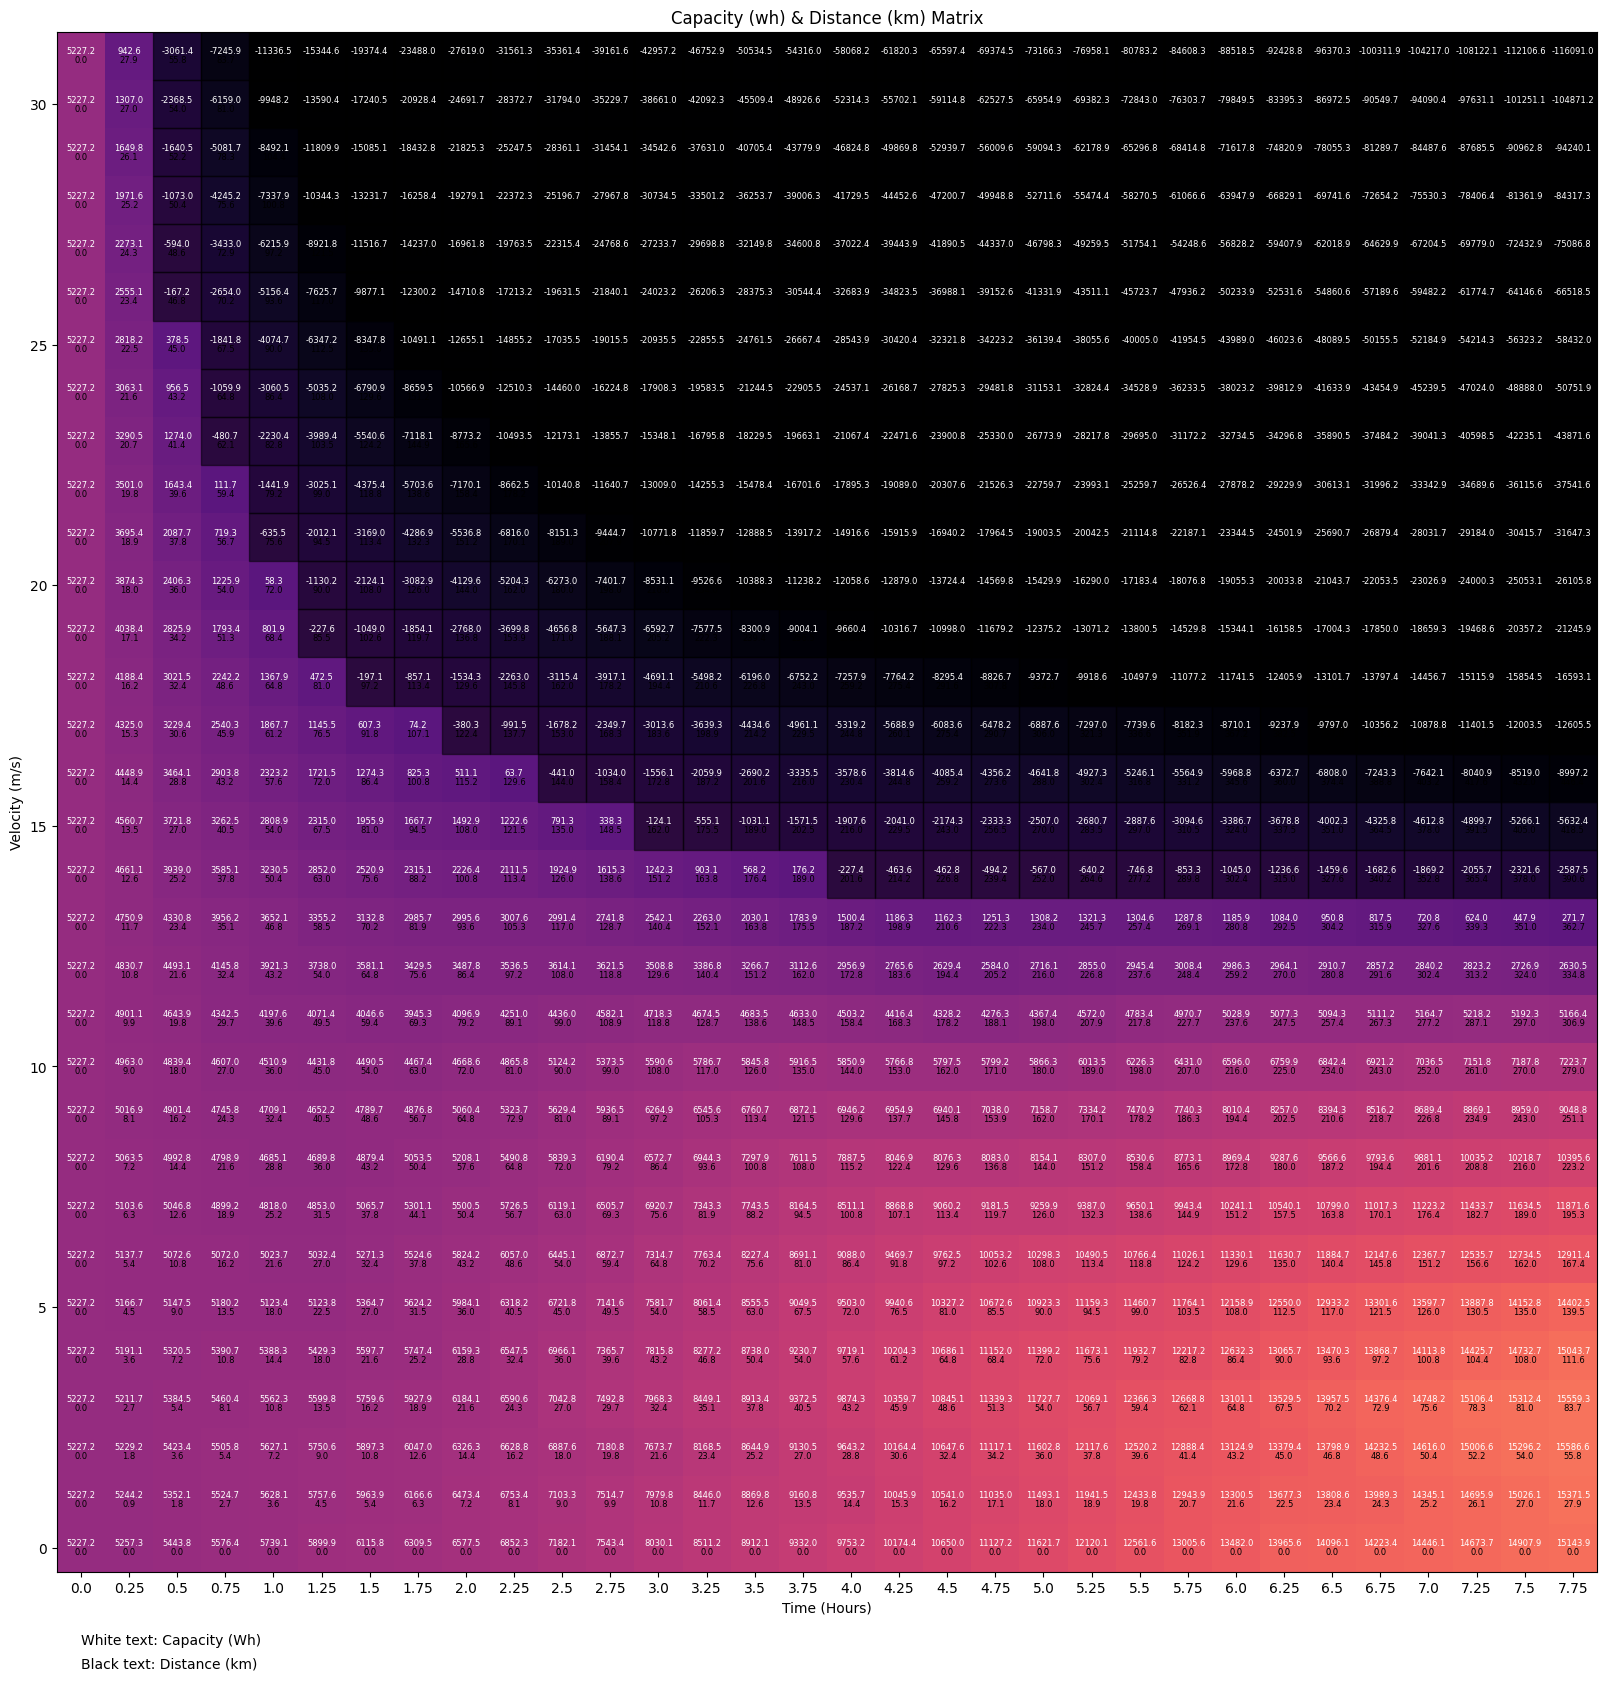

In [3]:
plt.figure(figsize=(20, 20))  # Width and height in inches
plt.title('Capacity (wh) & Distance (km) Matrix')
plt.xlabel('Time (Hours)')
plt.ylabel('Velocity (m/s)')
plt.imshow(capacity_values, cmap='magma', vmin=-10000, vmax=26000)
ax = plt.gca()
for (i, j), val in np.ndenumerate(capacity_values):
    if val < 0:
        rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, color='black', alpha=0.5)
        ax.add_patch(rect)
    plt.text(j, i, f'{val:.1f}', ha='center', va='bottom', color='white', fontsize='6')
    plt.text(j, i, f'{i * j * 0.9:.1f}', ha='center', va='top', color='black', fontsize='6')  # Product value
plt.xticks(ticks=np.arange(0, capacity_values.shape[1]), labels=[f'{i/4}' for i in range(capacity_values.shape[1])])
plt.text(0, -2.5, 'Black text: Distance (km)', color='black', fontsize='10')
plt.text(0, -2, 'White text: Capacity (Wh)', color='black', fontsize='10')
plt.gca().invert_yaxis()
plt.show

### Velocity Specific

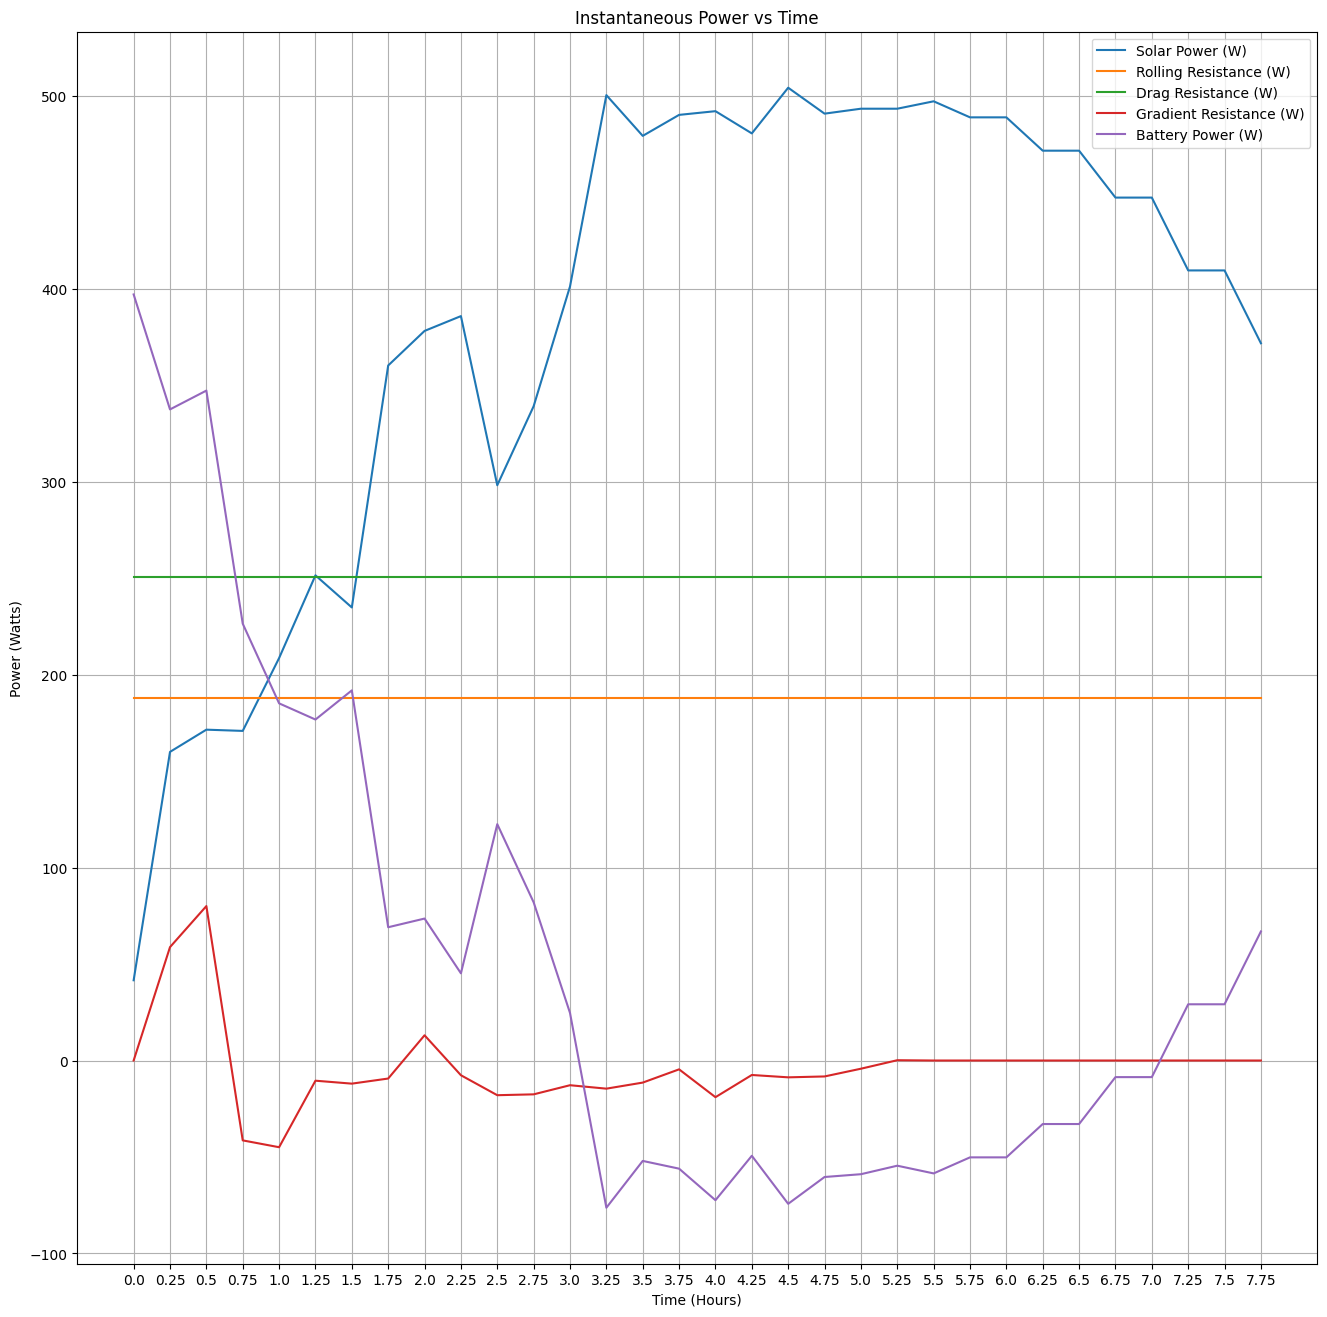

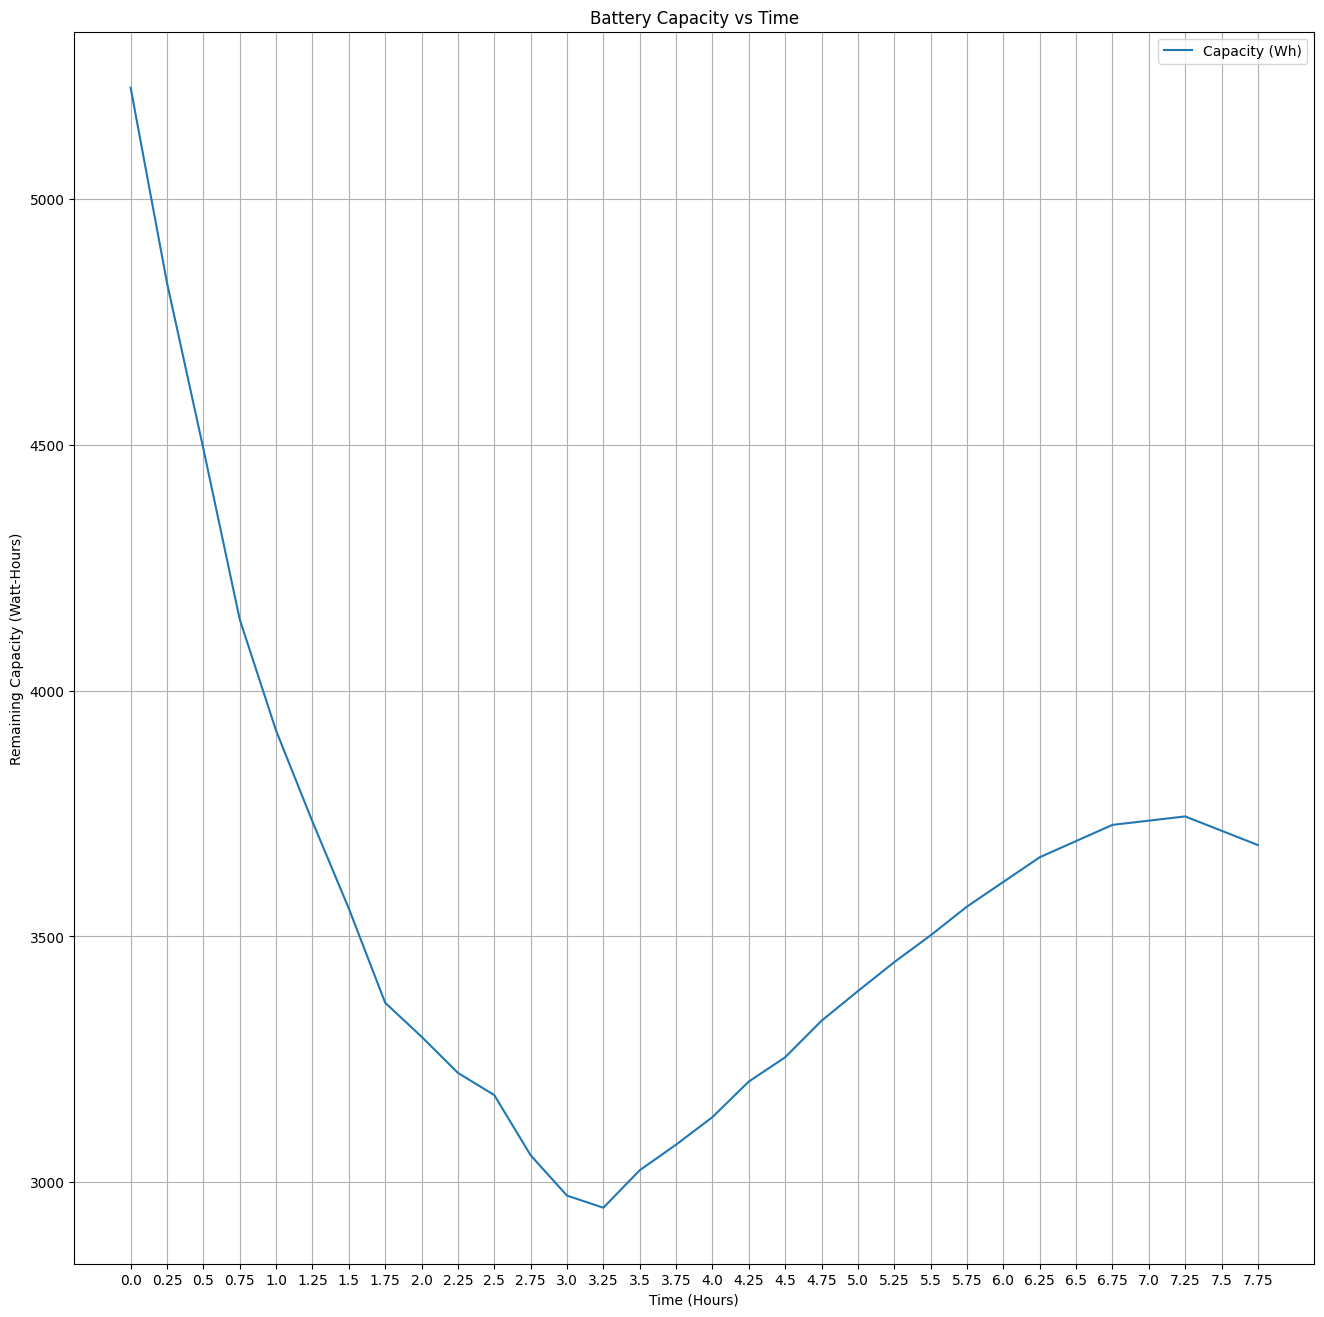

In [4]:
v = 12 # choose a velocity

plt.figure(figsize=(16, 16))
plt.plot(solar_power_values[v, :], label='Solar Power (W)')
plt.plot(rolling_resistance_values[v, :], label='Rolling Resistance (W)')
plt.plot(drag_resistance_values[v, :], label='Drag Resistance (W)')
plt.plot(gradient_resistance_values[v, :], label='Gradient Resistance (W)')
plt.plot(energy_consumed[v, :], label='Battery Power (W)')
plt.xlabel('Time (Hours)')
plt.ylabel('Power (Watts)')
plt.title('Instantaneous Power vs Time')
plt.xticks(ticks=np.arange(0, capacity_values.shape[1]), labels=[f'{i/4}' for i in range(capacity_values.shape[1])])
plt.legend()
plt.grid(True)

plt.figure(figsize=(16, 16))
plt.plot(capacity_values[v, :], label='Capacity (Wh)')
plt.xlabel('Time (Hours)')
plt.ylabel('Remaining Capacity (Watt-Hours)')
plt.title('Battery Capacity vs Time')
plt.xticks(ticks=np.arange(0, capacity_values.shape[1]), labels=[f'{i/4}' for i in range(capacity_values.shape[1])])
plt.legend()
plt.grid(True)

### Irradiance Time Graph


In [21]:
df = fetch_data("SELECT * from irradiance where left(route_model_id, 2) = '1A' ORDER BY period_end")

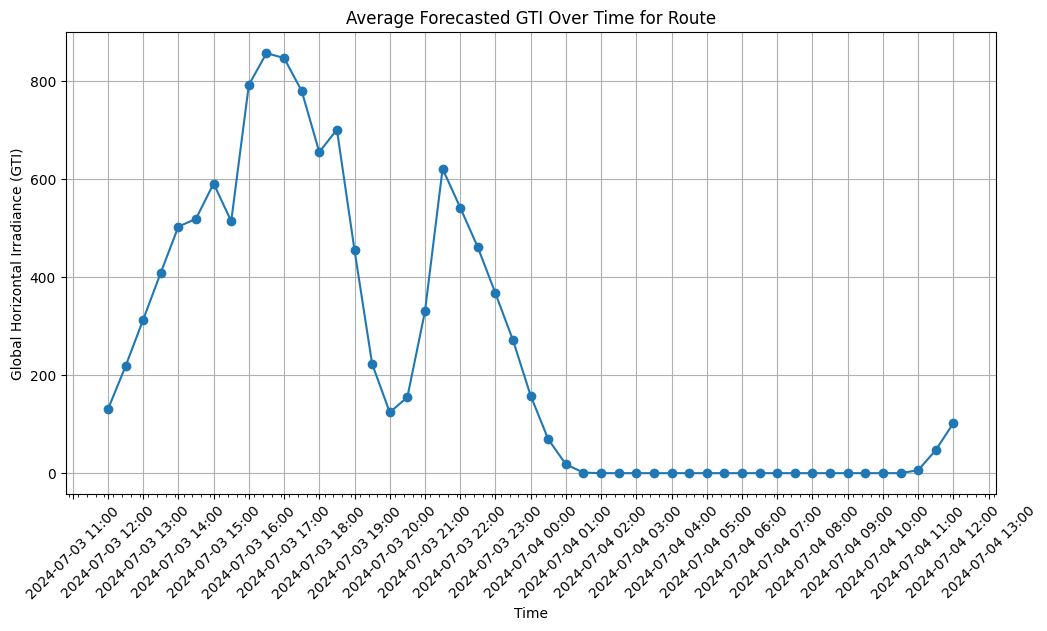

In [24]:
unique_routes = sorted(df['route_model_id'].unique())
middle_route = unique_routes[len(unique_routes) // 2]

forecasted_data = df[df['route_model_id'] == middle_route]
forecasted_data = forecasted_data.drop_duplicates(subset=['period_end'])

plt.figure(figsize=(12, 6))
plt.plot(forecasted_data['period_end'], forecasted_data['ghi'], marker='o')
plt.title('Average Forecasted GTI Over Time for Route')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (GTI)')
plt.xticks(rotation=45)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.show()

## FAQ

## Stage Overview
- Distance
- Elevation
    - Instantaneous
    - Total
- Irradiance
    - Instantaneous
    - Total

In [12]:
base_route_df, irradiance_df = load_data_to_memory()

In [13]:
STAGE_SYMBOL = '1A'

#### Distance

In [14]:
query = f"""
SELECT stage_elapsed_distance 
FROM base_route_df
WHERE symbol='{STAGE_SYMBOL}' 
ORDER BY id DESC 
LIMIT 1"""
df = psql.sqldf(query, locals())

stage_d = df['stage_elapsed_distance'].values[0]

print(f'Stage {STAGE_SYMBOL} total distance: {stage_d:.2f} km')
print(f'Stage {STAGE_SYMBOL} remaining distance: {stage_d-current_d:.2f} km')


Stage 1A total distance: 256632.55 km
Stage 1A remaining distance: 256632.55 km


#### Elevation Profile

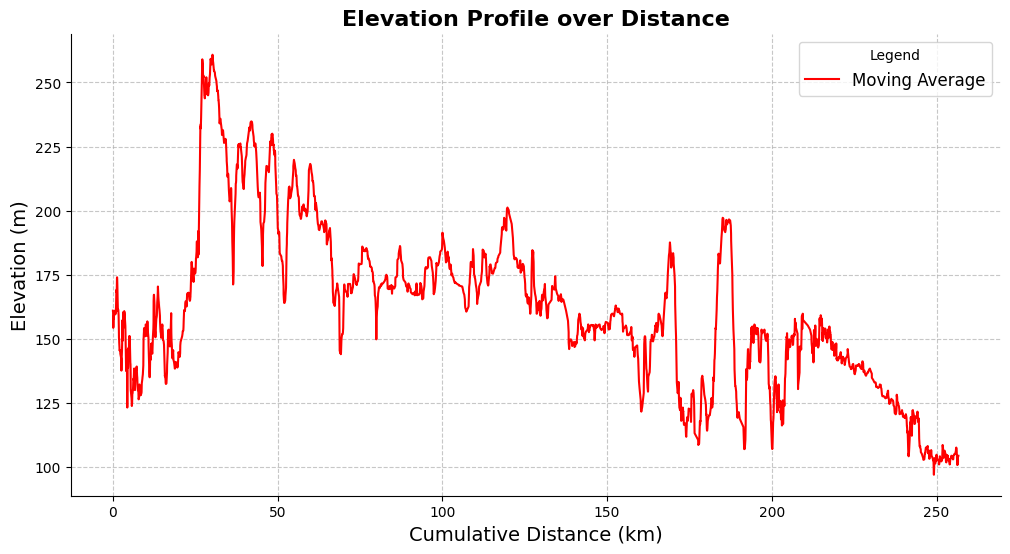

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

query = f"""
SELECT * 
FROM base_route_df 
WHERE symbol = '{STAGE_SYMBOL}' 
ORDER BY id"""
df = psql.sqldf(query, locals())

df['stage_elapsed_distance_km'] = df['stage_elapsed_distance'] / 1000

window_size = 5
df['moving_avg_elevation'] = df['elevation'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x='stage_elapsed_distance_km', y='moving_avg_elevation', data=df, label='Moving Average', color='red')

plt.title('Elevation Profile over Distance', fontsize=16, fontweight='bold')
plt.xlabel('Cumulative Distance (km)', fontsize=14)
plt.ylabel('Elevation (m)', fontsize=14)
plt.legend(title='Legend', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

sns.despine()

plt.show()

#### Elevation Gain

In [21]:
query = f"""
WITH elevation_data AS (
    SELECT
        MIN(elevation) AS first_elevation,
        MAX(elevation) AS last_elevation
    FROM
        base_route_df
    WHERE symbol = '1A'
)
SELECT
    first_elevation,
    last_elevation,
    last_elevation - first_elevation AS elevation_gain
FROM
    elevation_data;"""
df = psql.sqldf(query, locals())
df

,first_elevation,last_elevation,elevation_gain
0,95.0,262.0,167.0


#### Instantaneous Elevation

In [22]:
from db_funcs import map_distance_to_id
current_d = 300 # m

map_distance_to_id(base_route_df, STAGE_SYMBOL, current_d)

,id,name,description,longitude,latitude,weather_id,geopy_dist_from_last_m,geopy_elapsed_dist_m,elevation,symbol,stage_elapsed_distance,stage_id,car_bearing,car_direction,route_start_time,route_end_time,distance_difference
25,25,1A: Nashville to Paducah,Approx: 160 miles,-86.776187,36.14704,None,11.833253,302.42004,159.0,1A,302.42004,1A1,212.393879,South-West,2024-07-09 14:00:00,2024-07-20 17:15:00,2.42004


#### Irradiance

/var/folders/c1/s0gfrcl17njd06w_lmv6cvgm0000gn/T/ipykernel_6698/61457351.py:11: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  df = psql.sqldf(query, locals())


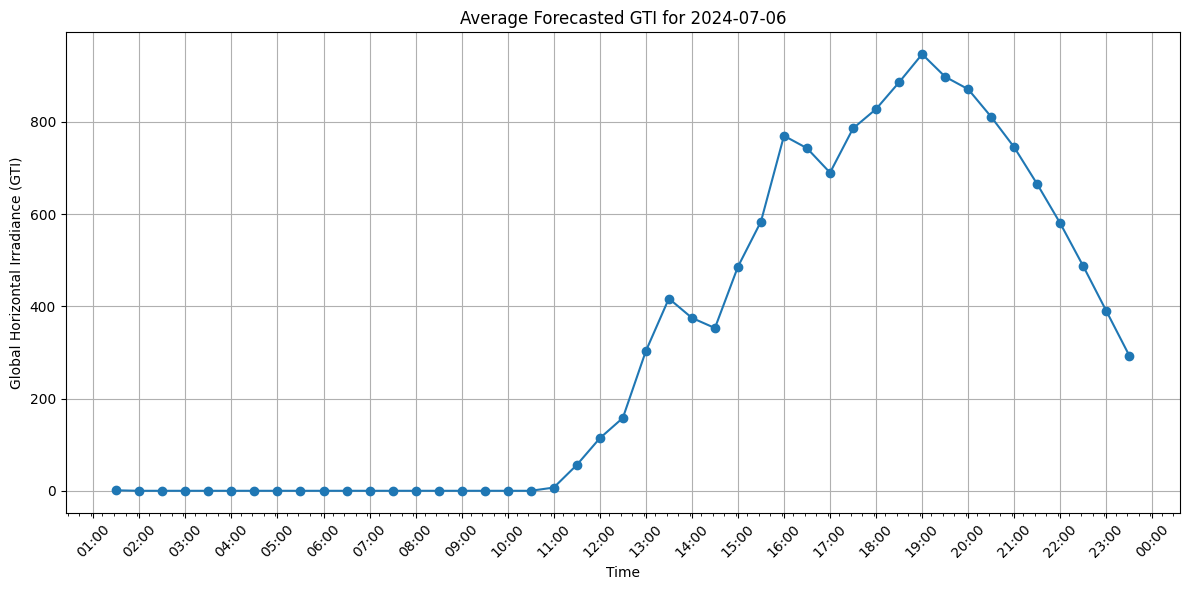

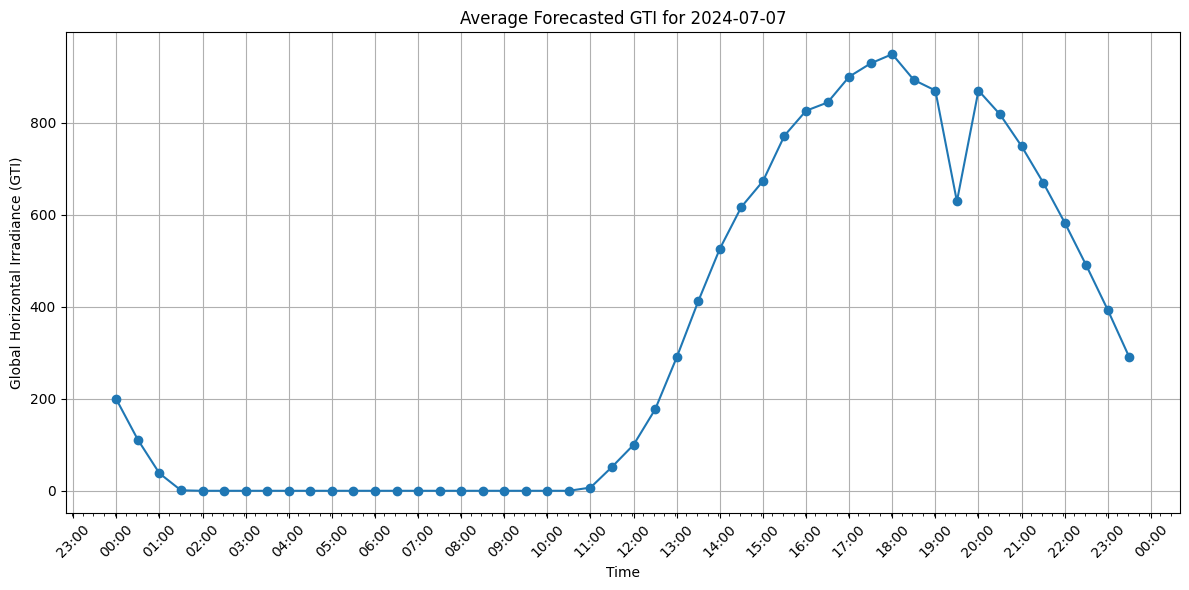

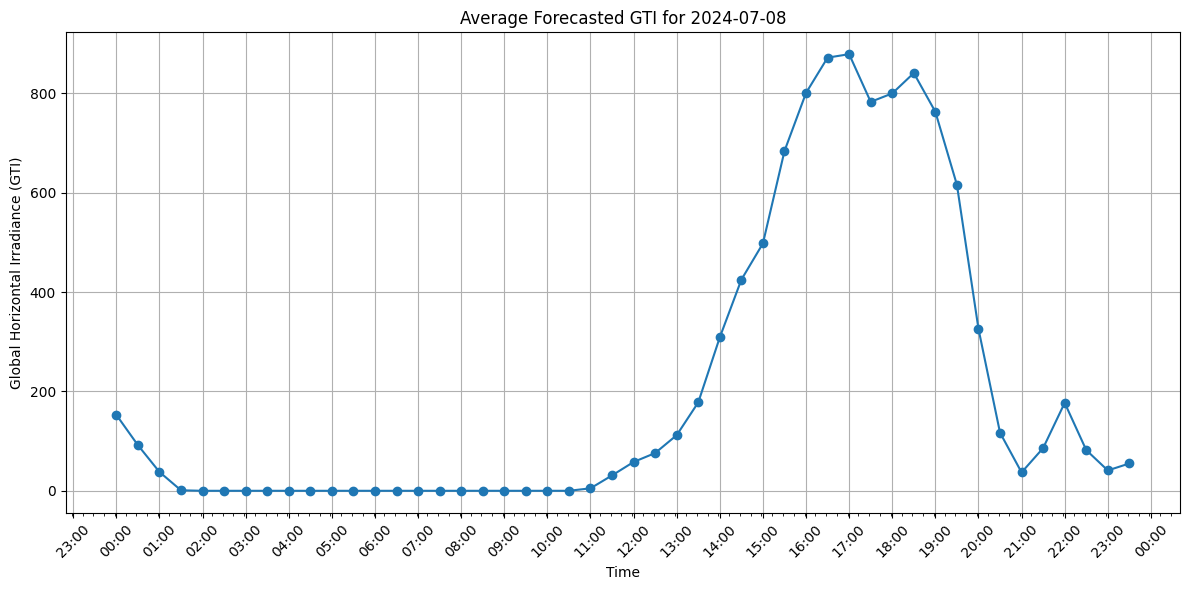

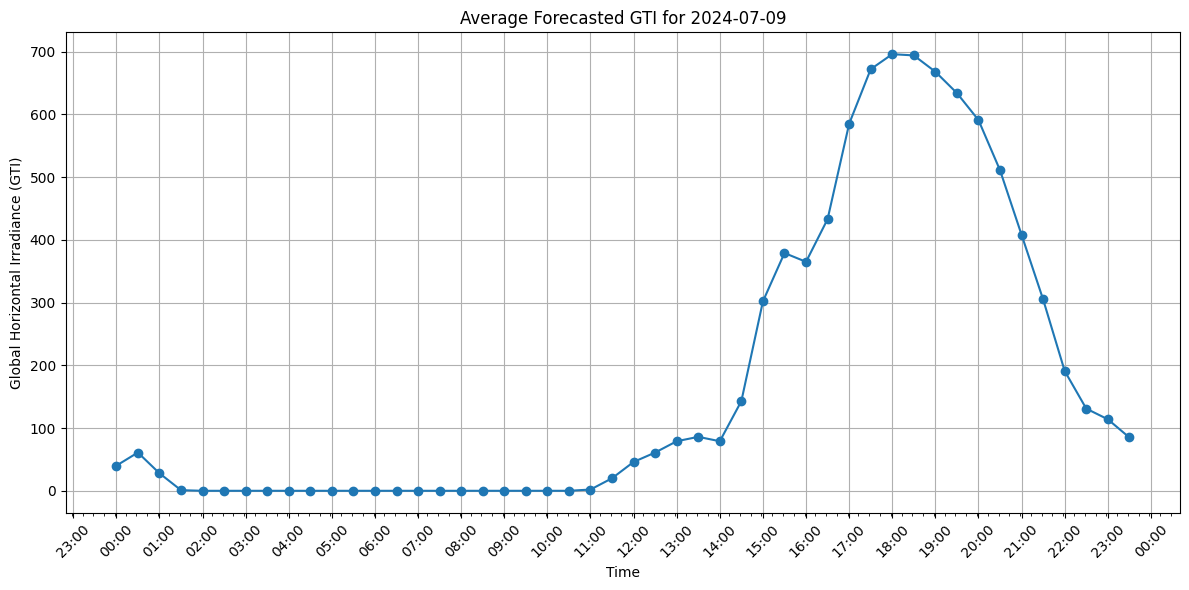

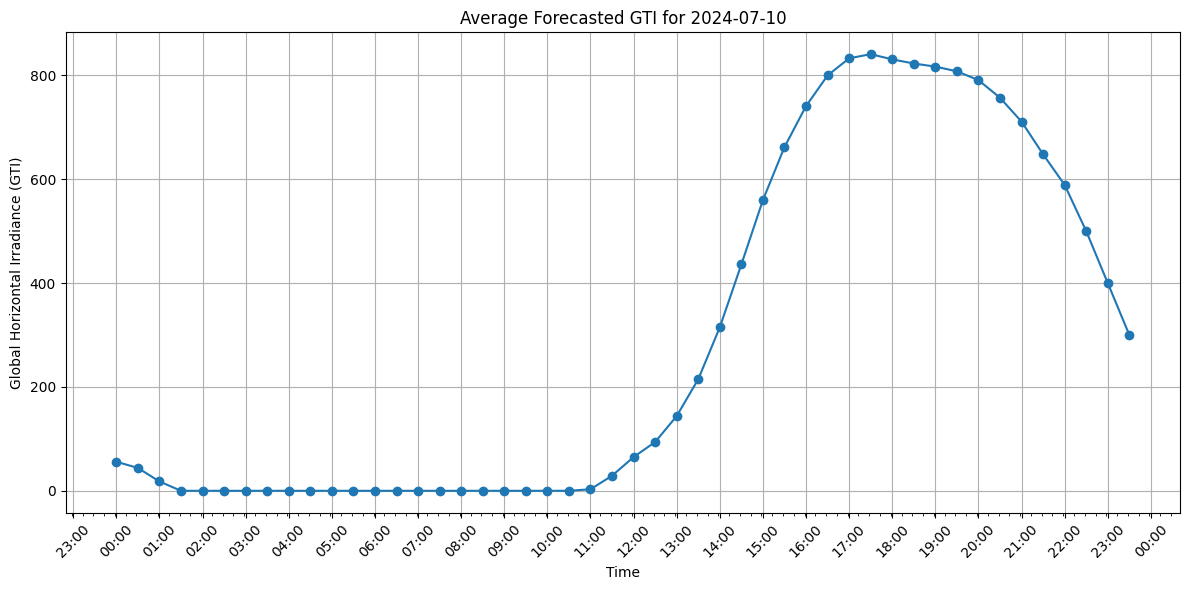

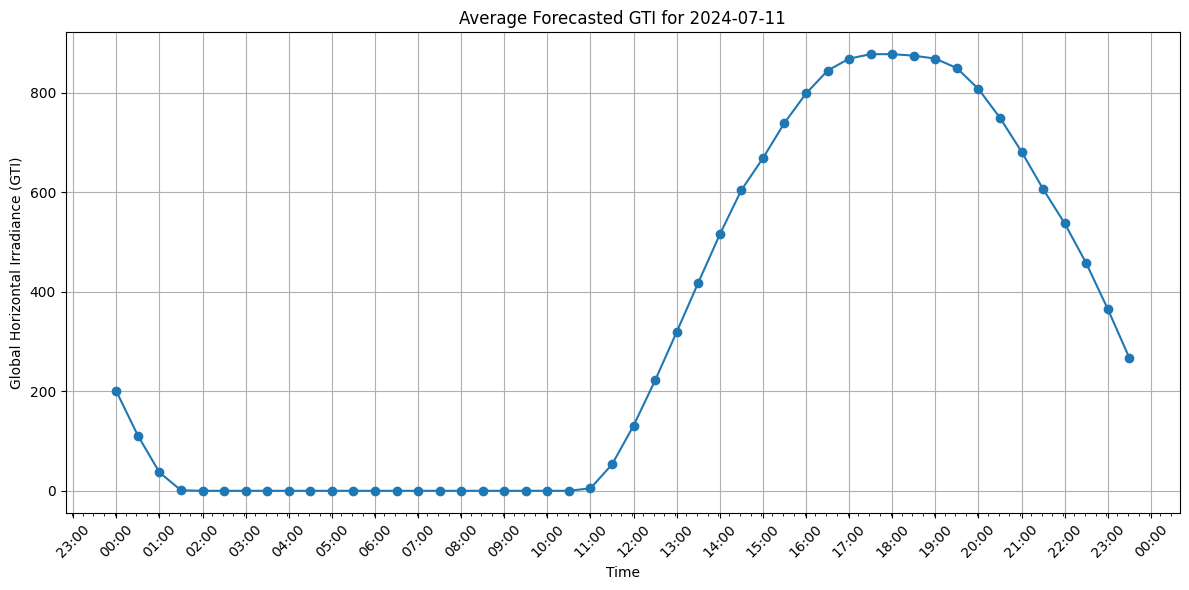

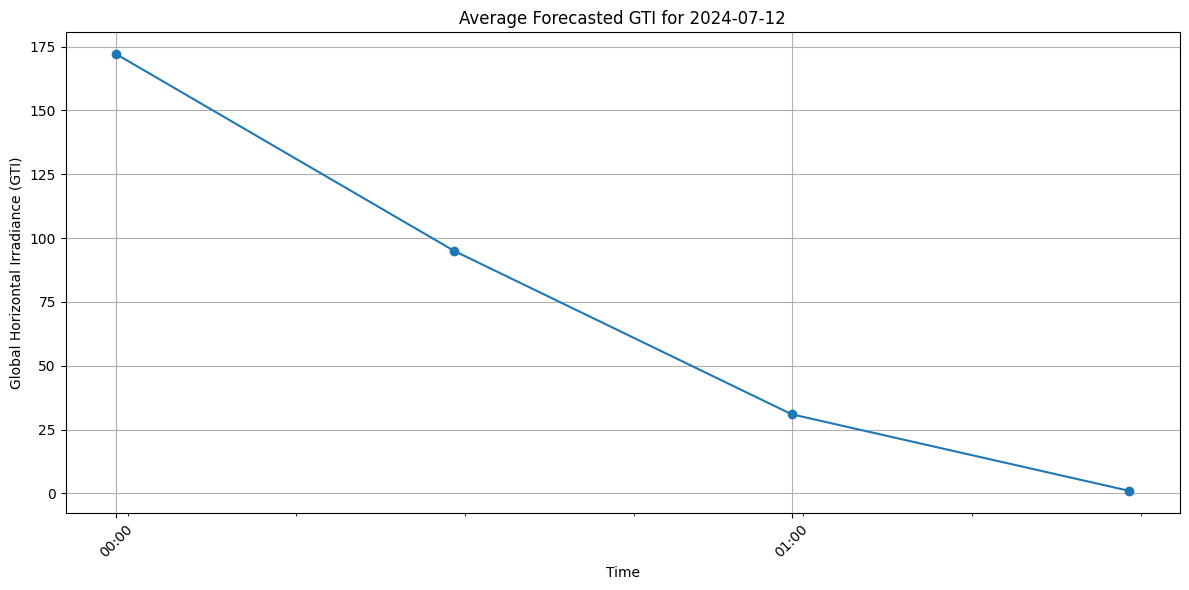

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

query = f"""
SELECT *
FROM irradiance_df
WHERE substr(route_model_id, 1, 2) = '{STAGE_SYMBOL}'
ORDER BY period_end;"""

df = psql.sqldf(query, locals())

unique_routes = sorted(df['route_model_id'].unique())

middle_route = unique_routes[len(unique_routes) // 2]

forecasted_data = df[df['route_model_id'] == middle_route]

forecasted_data = forecasted_data.drop_duplicates(subset=['period_end'])

# Convert period_end to datetime if it isn't already
forecasted_data['period_end'] = pd.to_datetime(forecasted_data['period_end'])

# Get unique dates
unique_dates = forecasted_data['period_end'].dt.date.unique()

for unique_date in unique_dates:
    daily_data = forecasted_data[forecasted_data['period_end'].dt.date == unique_date]
    
    plt.figure(figsize=(12, 6))
    plt.plot(daily_data['period_end'], daily_data['ghi'], marker='o')
    plt.title(f'Average Forecasted GTI for {unique_date}')
    plt.xlabel('Time')
    plt.ylabel('Global Horizontal Irradiance (GTI)')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gca().xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    plt.tight_layout()
    plt.show()


In [29]:
forecasted_data


,id,air_temp,ghi,period_end,period,route_model_id,gti,clearsky_ghi,clearsky_gti,dewpoint_temp,precipitation_rate,relative_humidity,wind_direction_10m,wind_speed_10m,data_type,last_updated_time
67,120197,23,1,2024-07-06 01:30:00.000000,1800000000000,1A48,1,1,1,19.0,0.0,78.4,353,2.1,live,2024-07-08 21:04:13.605894
140,120196,22,0,2024-07-06 02:00:00.000000,1800000000000,1A48,0,0,0,18.3,0.0,78.8,2,1.9,live,2024-07-08 21:04:13.605894
213,120195,22,0,2024-07-06 02:30:00.000000,1800000000000,1A48,0,0,0,17.8,0.0,78.9,7,1.5,live,2024-07-08 21:04:13.605894
286,120194,21,0,2024-07-06 03:00:00.000000,1800000000000,1A48,0,0,0,17.4,0.0,78.6,7,1.0,live,2024-07-08 21:04:13.605894
359,120193,21,0,2024-07-06 03:30:00.000000,1800000000000,1A48,0,0,0,17.1,0.0,78.0,14,0.4,live,2024-07-08 21:04:13.605894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24030,120048,28,267,2024-07-11 23:30:00.000000,1800000000000,1A48,208,280,213,21.1,0.0,64.6,253,0.9,forecast,2024-07-08 21:04:07.294154
24115,120049,28,172,2024-07-12 00:00:00.000000,1800000000000,1A48,120,184,119,21.0,0.0,66.6,231,0.9,forecast,2024-07-08 21:04:07.294154
24200,120050,27,95,2024-07-12 00:30:00.000000,1800000000000,1A48,52,98,49,20.6,0.0,68.1,215,1.0,forecast,2024-07-08 21:04:07.294154
24285,120051,26,31,2024-07-12 01:00:00.000000,1800000000000,1A48,21,31,20,19.9,0.0,69.0,206,1.2,forecast,2024-07-08 21:04:07.294154
